## Intro to Path Integral

#### Muhammad Gaffar

-------------------------------------

Often, it is impossible to compute the convolution of density matrix analytically. Also, Computer is hardly can compute the matrix squaring with reasonably discretized $x$. The idea of quantum monte carlo becomes relevant here, it led to feynman path integral.

Instead, evaluation the convolution operation one of after another, we can express the density matrix in the chunk of integral of higher temperature density of matrix

$$
\rho(x_0,x_N,\beta) = \int \dots \int dx_1 \dots dx_{N-1} \;\; \underbrace{\rho\left(x_0,x_1,\frac{\beta}{N}\right) \dots \rho\left(x_{N-1},x_{N},\frac{\beta}{N}\right)}_{\text{sequence of weight for each}\; x_i}
$$

for partition function, there are more integration over the variable $x_0$

$$
Z = \int dx_0 \; \rho(x_0,x_0,\beta) = \int \dots \int dx_0 \dots dx_{N-1} \;\; \rho\left(x_0,x_1,\frac{\beta}{N}\right) \dots \rho\left(x_{N-1},x_{0},\frac{\beta}{N}\right)
$$

the sequence of $\lbrace x_0,...,x_N \rbrace$ is called path. Density matrices and partition function are thus represented in path integral.

### Path Sampling

#### A. Naive Sampling

Let us sample of path contributing to partition function, using harmonic oscillator potential

$$
V(x) = \frac{1}{2}m\omega^2 x^2 \equiv \frac{1}{2}x^2
$$

using Trotter formula, the weight of each path of $x_k$ is given by

$$
\rho_0(x_{k-1},x_k,\Delta_\tau)e^{-\frac{1}{2}\Delta_\tau V(x_k)} e^{-\frac{1}{2}\Delta_\tau V(x_k)}\rho_0(x_{k},x_{k+1},\Delta_\tau) = \rho_0(x_{k-1},x_k,\Delta_\tau)\rho_0(x_{k},x_{k+1},\Delta_\tau)e^{-\frac{1}{2}\Delta_\tau x_k^2}
$$

Using markov chain monte carlo, we see that from above, the move probability of $x_k$ is determined by $x_{k-1}$ and $x_{k+1}$

Now, we gonna use the path integral to compute the $\pi(x) = \rho(x,x,\beta)$ and compare it to analytically exact harmonic oscillator potential, where it can be derived to get

$$
\rho(x,x,\beta) = \frac{1}{\sqrt{2\pi\sinh(\beta)}}\exp\left[-x^2\tanh\left(\frac{\beta}{2}\right)\right]
$$

In [1]:
"""
Free density matrix
"""
function ρ0(x1,x2,β)
    A = 1 / sqrt(2π * β)
    B = exp(- (x1-x2)^2 / 2β)
    return A * B
end

"""
ρ(x,x,β) of harmonic oscillator potential, where V(x) = 1/2 * x^2
"""
function ρ_diag_harmonic(x,β)
    A = 1/(2π*sinh(β))
    B = exp(-x^2 * tanh(β/2))
    return sqrt(A) * B
end

"""
Markov chain monte carlo procedure

1. Generate initial path, x = {x1,x2,...,xN}
2. Imaginary time increment, Δτ = β / N
3. choice x index and the index of its neighbors, 
        k  = rand(1,N)
        k+ = k + 1
        k- = k - 1
        if k- = 0 then k- => N + 1 # make sure the periodicity of path
4. move x[k]
        x_old = x[k]
        x_new = x[k] + rand(-δ,δ)
5. accept or reject the x_new ?
        π(x_old) = ρ(x-,x_old,Δτ) * ρ(x_old,x+,Δτ) * exp(-x_old^2 / 2)
        π(x_new) = ρ(x-,x_new,Δτ) * ρ(x_new,x+,Δτ) * exp(-x_new^2 / 2)
   accept if rand(0,1) < π(x_new) / π(x_old)
        x[k] = x_new

6. save the acceptance of path position
"""
function naive_harmonic(β,N,niter;x_in=nothing)
    #initialization
    Δτ = β/N
    if x_in == nothing
        x = zeros(Float64,N+1)
    else
        x = x_in
    end
    
    hist = []
    
    #start markov chain monte carlo
    for i in 1:niter
        k = rand(1:N)
        kp = k + 1
        km = k - 1
        if km == 0
            km = N + 1
        end

        xk_move = x[k] + (rand()-0.5)
        
        πa = ρ0(x[km],x[k],Δτ) * ρ0(x[k],x[kp],Δτ) * exp(-0.5*Δτ*x[k]^2)
        πb = ρ0(x[km],xk_move,Δτ) * ρ0(xk_move,x[kp],Δτ) * exp(-0.5*Δτ*xk_move^2)
        γ  = πb / πa
        if rand() < γ
            x[k] = xk_move
            push!(hist,x[k])
        end
        x[N] = x[1]
    end
    
    return hist,x
end;

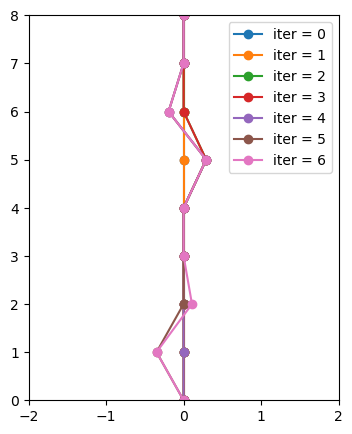

In [2]:
using PyPlot

x = zeros(9)
plt.figure(figsize=(4,5))
plt.plot(x,0:length(x)-1,"-o",label = "iter = 0")

β = 4
N = 8
for i in 1:6
    global x
    hist,x = naive_harmonic(β,N,1,x_in=x)
    plt.plot(x,0:length(x)-1,"-o",label = "iter = $i")
    xlim(-2,2)
    ylim(0,length(x)-1)
end
legend();

We compare the monte carlo result with exact result

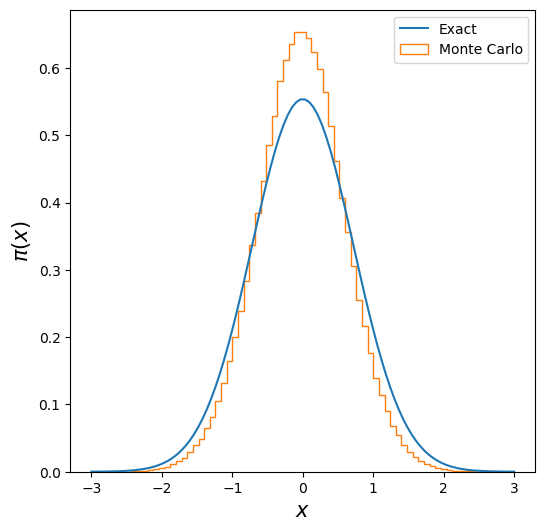

In [3]:
using NumericalIntegration

β = 4

fig,ax = plt.subplots(figsize=(6,6))
#exact result
x_path = LinRange(-3,3,100)
y = ρ_diag_harmonic.(x_path,β)
norm = integrate(x_path,y)
y ./= norm
ax.plot(x_path,y,label="Exact")

#quantum monte carlo
N = 8
hst,x = naive_harmonic(β,N,1e6);
ax.hist(hst,bins=75,density=true,histtype="step",range=(-3,3),label="Monte Carlo");

ax.set_ylabel(L"\pi(x)",fontsize=15)
ax.set_xlabel(L"x",fontsize=15)
legend();

Path sampling above is local sampling, and it is slow (that's why called naive). A position $x_k$ cannot get far away from $x_{k-1}$ and $x_{k+1}$, thus the computed free density matrix is becomes very small. Local path sampling is unfit for complicated problems.